# Imports

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Flatten, Masking, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import string
from nltk.stem import WordNetLemmatizer as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder as le
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2022-08-29 16:53:14.812595: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-29 16:53:14.846466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 16:53:14.846482: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
csv_path = '../raw_data'
lyricsdf = pd.read_csv(os.path.join(csv_path, 'song_lyrics.csv'))
recipesdf = pd.read_csv(os.path.join(csv_path, 'recipes.csv'))
fooddf = pd.read_csv(os.path.join(csv_path, 'food_reviews.csv'))
bookdf = pd.read_csv(os.path.join(csv_path, 'book_descriptions.csv'))
cleanfake = pd.read_csv(os.path.join(csv_path, 'clean_data_Fake.csv'))
cleantrue = pd.read_csv(os.path.join(csv_path, 'clean_data_True.csv'))

In [3]:
lyricsdf, recipesdf, fooddf, bookdf, cleanfake, cleantrue

(       Artist                                  Title  \
 0      Khalid                     Young Dumb & Broke   
 1      Khalid                               Location   
 2      Khalid                                 Better   
 3      Khalid                                   Talk   
 4      Khalid                                  Saved   
 ...       ...                                    ...   
 4163  Beyoncé  Check On It (Beyoncé Experience Live)   
 4164  Beyoncé     Ring The Alarm (Tranzformas Remix)   
 4165  Beyoncé                           Radio (Live)   
 4166  Beyoncé     Ring The Alarm (Karmatronic Remix)   
 4167  Beyoncé        Denial (Hold Up, Beyoncé, Poem)   
 
                             Album    Year        Date  \
 0                   American Teen  2017.0  2017-03-03   
 1                   American Teen  2016.0  2016-04-30   
 2                         Suncity  2018.0  2018-09-14   
 3                     Free Spirit  2019.0  2019-02-07   
 4                   Ame

# Variables

In [4]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [5]:
binacc = BinaryAccuracy()
prec = Precision()
rec = Recall()

2022-08-29 16:53:29.085457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-29 16:53:29.085679: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-29 16:53:29.085884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-0UJ0SON8): /proc/driver/nvidia/version does not exist
2022-08-29 16:53:29.087345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
stop_words = stopwords.words('english')

# Functions

In [7]:
def lematize (words):
    for index, word in enumerate (words):
        words[index] = wn().lemmatize(word, pos='v')
    for index, word in enumerate (words):
        words[index] = wn().lemmatize(word, pos='r')
    for index, word in enumerate (words):
        words[index] = wn().lemmatize(word, pos='a')
    for index, word in enumerate (words):
        words[index] = wn().lemmatize(word, pos='n')
    for index, word in enumerate (words):
        words[index] = wn().lemmatize(word, pos='s')
    return ' '.join(words)

In [8]:
def preprocessing(sentence):
    sentence = sentence.strip()
    
    sentence = sentence.lower()
    
    sentence = ''.join(char for char in sentence if not char.isdigit())
    
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, ' ') 
    
    sentence = sentence.strip()
    
    sentence = word_tokenize (sentence)
    final = []
    for word in sentence:
        if word in stop_words:
            sentence.remove(word)
        if len(word) >= 3:
            final.append(word)
            
    lematize(final)
            
    return ' '.join(final)

In [9]:
def plot_loss_accuracy(history, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(f'{title} Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['binary_accuracy'])
    ax2.plot(history.history['val_binary_accuracy'])
    ax2.set_title(f'{title} Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_title(f'{title} Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=2)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)    
    
    ax4.plot(history.history['recall'])
    ax4.plot(history.history['val_recall'])
    ax4.set_title(f'{title} Recall')
    ax4.set_ylabel('Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylim(ymin=0, ymax=2)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)  
    
    plt.show()

In [10]:
def initialize_model (model_name, neurons):
    model = Sequential()
    model.add(Embedding(
        input_dim=(len(tokenizer.word_index))+1, # +1 for the 0 padding
        input_length=300, # Max_sentence_length (optional, for model summary)
        output_dim=100,
        mask_zero=True, # Built-in masking layer :)
    ))
    if model_name == 'lstm':
        model.add(LSTM((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'gru':
        model.add(GRU((neurons*2), return_sequences=False))
        model.add(Dense((neurons), activation='relu'))
    if model_name == 'cnn':
        model.add(Conv1D(neurons, kernel_size=5, activation='tanh'))
        model.add(Flatten())
        model.add(Dense((neurons/2), activation='relu'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [11]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=[binacc, prec, rec]) 
    return model

# Preparing data

In [12]:
food_proc = fooddf['Text'].apply(preprocessing)
food_proc

0        once saw peanut butter and cereal please that ...
1        great natural treat for cat whose health stron...
2        great treat each into piece for week puggle th...
3        this snack food and think this the taste cerea...
4        this buy this regularly back during thoroughly...
                               ...                        
27995    nothing website amazon com let know these be n...
27996    all these helper make but have dull ache all t...
27997    eat this every day and rather other pack becau...
27998    great coffee flavor even when dash milk strong...
27999    this nummy and bar with goodness the granola b...
Name: Text, Length: 28000, dtype: object

In [13]:
book_proc = bookdf['description'].apply(preprocessing)
book_proc

0        jeffery masson begin be about year two chick t...
1        this biography from american bar association v...
2        introduction sa statistical software foundatio...
3        do know that cornish pasty be tin miner from p...
4        interaction mosaic silver edition fully integr...
                               ...                        
27995    when break free from habit that world open let...
27996    the book present the and assumption behavioral...
27997    best sell book save the go movie blake snyder ...
27998    book two annihilate you read the volume before...
27999    strategy and collide fey history carrier us or...
Name: description, Length: 28000, dtype: object

In [14]:
recipes_proc = recipesdf['full'].apply(preprocessing)
recipes_proc

0        pan sear steak vegetable noodle soup garnish w...
1        spinach and soup this cold winter month serve ...
2        spinach and miso soup this simple soup full an...
3        corn dip and unlike anything you have once the...
4        sunday chicken rice bake warm and casserole wi...
                               ...                        
27995    spinach salad with spinach good for and waistl...
27996    slow bake tomato with and from home and websit...
27997    pumpkin harvest muffin the add moisture nice f...
27998    low fat blueberry muffin with these the muffin...
27999    homemade vegetable dip this always make when p...
Name: full, Length: 28000, dtype: object

In [15]:
lyrics_proc = lyricsdf['Lyric'].apply(preprocessing)
lyrics_proc

0       think just you not you you moment this just du...
1       send location let cause need the and through t...
2       well nothing baby nothing feel well not drink ...
3       can just can just talk about goin before get l...
4       the part always seem forever sometimes that ar...
                              ...                        
4163    ooh boy you like you what see win you over che...
4164    refrain ring the be this long but damn see ano...
4165    you the one that allow out with door close and...
4166    refrain ring the be this long but damn see ano...
4167    close more soft pretty le awake fast for wear ...
Name: Lyric, Length: 4168, dtype: object

In [35]:
samples = 13575
notnewsdf = pd.DataFrame(pd.concat([book_proc.sample(samples), food_proc.sample(samples), recipes_proc.sample(samples), lyrics_proc], ignore_index=True), columns=['text'])
notnewsdf = notnewsdf.sample(n=len(notnewsdf), ignore_index=True)

In [36]:
notnewsdf['target'] = 0
notnewsdf

,text,target
0,nando tasty and sauce from norm little bottle ...,0
1,this facsimile reprint and contain imperfectio...,0
2,not for family but the be they fell out,0
3,the plan and and that handbook teach your all ...,0
4,pea salad pea salad pea onion hard boil egg ma...,0
...,...,...
44888,use whole chicken big green egg will use anyth...,0
44889,ever worth join provide protection trouble nei...,0
44890,imperial fondue dip sauce selection prepare di...,0
44891,taylor swift tear stream down face when say ne...,0


In [37]:
newsdf = pd.concat([cleanfake, cleantrue], ignore_index=True)
newsdf = newsdf.sample(n=len(newsdf), ignore_index=True)

In [38]:
newsdf['target'] = 1
newsdf

,text,target
0,black room reveal fox news secret spy network ...,1
1,document reveal hillary clinton strike deal ke...,1
2,catalan prepare defy madrid ban independence v...,1
3,philippine police chief defend deadly drug war...,1
4,eighth person trump tower meet link money laun...,1
...,...,...
44893,habitual liar remember touch story hillary tel...,1
44894,jerry springer react trump debate performance ...,1
44895,black republican brilliant neurosurgeon announ...,1
44896,trump corker spat complicate drive tax reform ...,1


In [39]:
fulldf = pd.concat([newsdf, notnewsdf], ignore_index=True)
fulldf = fulldf.sample(n=len(fulldf), ignore_index=True)

In [40]:
fulldf

,text,target
0,trump literally stop gop debate inform u size ...,1
1,conway declare unpatriotic question trump ment...,1
2,four hour champange diet spill while you try j...,0
3,republican marco rubio win wall street fundrai...,1
4,supreme court justice reveal want beat justice...,1
...,...,...
89786,trump virginia comment last straw disenchant c...,1
89787,sausage this meat dish best serve over potato ...,0
89788,sunday screen gun drug cia week documentary sc...,1
89789,desperate venezuelan peddle war door door colo...,1


# Testing model

In [41]:
X_train, X_test, y_train, y_test = train_test_split(fulldf['text'], fulldf['target'], test_size=0.25)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
X_train_token = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=300)
X_test_token = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=300)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          14063000  
                                                                 
 conv1d (Conv1D)             (None, 296, 12)           6012      
                                                                 
 flatten (Flatten)           (None, 3552)              0         
                                                                 
 dense (Dense)               (None, 6)                 21318     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 14,090,337
Trainable params: 14,090,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2340/2340 [======================

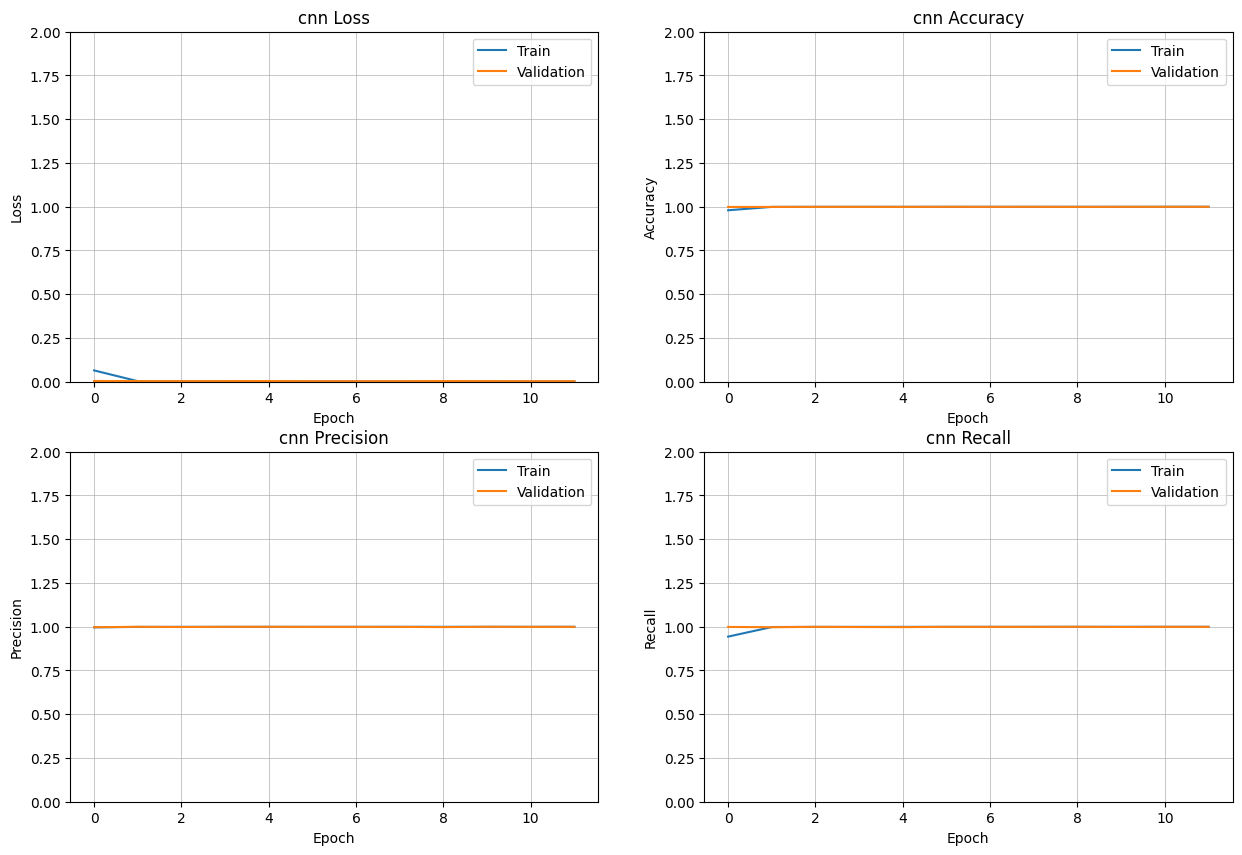

CPU times: user 48min 5s, sys: 2min 36s, total: 50min 42s
Wall time: 13min 1s


In [25]:
%%time
model = compile_model(initialize_model('cnn', 12))
model.summary()
history = model.fit(X_train_token, y_train, 
      epochs=30, 
      batch_size=32,
      validation_split=0.25,
      callbacks=[es],
    verbose = 1, 
    use_multiprocessing=True
      )
model.evaluate(X_test_token, y_test, verbose=1)
plot_loss_accuracy(history, 'cnn')

# Conclusion: we're good to go!

# Saving model

In [ ]:
model.save('../fake-news/models/notnewsfromnews.tf')

# Saving tokenizer

In [42]:
import pickle

In [43]:
# saving
with open('../fake-news/tokenizers/notnewsfromnews.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)